**MODEL-1**
**Content Based Movie Recommandation Model**

In [3]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features for ratings.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})

# Select the features for movies.
movies = movies.map(lambda x: x["movie_title"])

user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

class MovieLensContentBasedModel(tfrs.Model):

    def __init__(
        self,
        user_model: tf.keras.Model,
        movie_model: tf.keras.Model,
        task: tfrs.tasks.Retrieval):
        super().__init__()

        # Set up user and movie representations.
        self.user_model = user_model
        self.movie_model = movie_model

        # Set up a retrieval task.
        self.task = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        return self.task(user_embeddings, movie_embeddings)

# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(lambda title: (title, movie_model(title)))
))

# Create a retrieval model.
model = MovieLensContentBasedModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train for 3 epochs.
model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

# Get some recommendations.
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")



Epoch 1/3
25/25 [==============================] - 114s 4s/step - factorized_top_k/top_1_categorical_accuracy: 6.2000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0071 - factorized_top_k/top_10_categorical_accuracy: 0.0169 - factorized_top_k/top_50_categorical_accuracy: 0.1125 - factorized_top_k/top_100_categorical_accuracy: 0.1611 - loss: 673618.1782 - regularization_loss: 0.0000e+00 - total_loss: 673618.1782
Epoch 2/3
25/25 [==============================] - 104s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0244 - factorized_top_k/top_10_categorical_accuracy: 0.0710 - factorized_top_k/top_50_categorical_accuracy: 0.3066 - factorized_top_k/top_100_categorical_accuracy: 0.3106 - loss: 37179.2224 - regularization_loss: 0.0000e+00 - total_loss: 37179.2224
Epoch 3/3
25/25 [==============================] - 106s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categorical_accurac

**Model-2 Neural collaborative filtering(NCF) model**

In [4]:
# @title
!pip install -q tensorflow-recommenders
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the user and movie model.
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Define the NCF model.
class NCFModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

        # Neural network layers
        self.dense_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1)
        ])

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        # Concatenate user and movie embeddings
        concatenated_embeddings = tf.concat([user_embeddings, movie_embeddings], axis=1)

        # Pass through dense layers
        output = self.dense_layers(concatenated_embeddings)

        return self.task(user_embeddings, movie_embeddings)

# Define the retrieval task.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
))

# Create and compile the model.
model = NCFModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train the model.
model.fit(ratings.batch(4096), epochs=3)

# Set up brute-force search for retrieval.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Get recommendations.
_, titles = index(np.array(["100"]))
print(f"Top 3 recommendations for user 100: {titles[0, :3]}")


Epoch 1/3


25/25 [==============================] - 37s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.1000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0017 - factorized_top_k/top_10_categorical_accuracy: 0.0051 - factorized_top_k/top_50_categorical_accuracy: 0.0455 - factorized_top_k/top_100_categorical_accuracy: 0.1031 - loss: 33084.2802 - regularization_loss: 0.0000e+00 - total_loss: 33084.2802
Epoch 2/3
25/25 [==============================] - 35s 1s/step - factorized_top_k/top_1_categorical_accuracy: 2.2000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0143 - factorized_top_k/top_50_categorical_accuracy: 0.1050 - factorized_top_k/top_100_categorical_accuracy: 0.2093 - loss: 31015.7569 - regularization_loss: 0.0000e+00 - total_loss: 31015.7569
Epoch 3/3
25/25 [==============================] - 34s 1s/step - factorized_top_k/top_1_categorical_accuracy: 6.9000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.00

**Model-3 Data exploration and Visualization Model**

Index(['movie_genres', 'movie_id', 'movie_title'], dtype='object')
Index(['bucketized_user_age', 'movie_genres', 'movie_id', 'movie_title',
       'raw_user_age', 'timestamp', 'user_gender', 'user_id',
       'user_occupation_label', 'user_occupation_text', 'user_rating',
       'user_zip_code'],
      dtype='object')


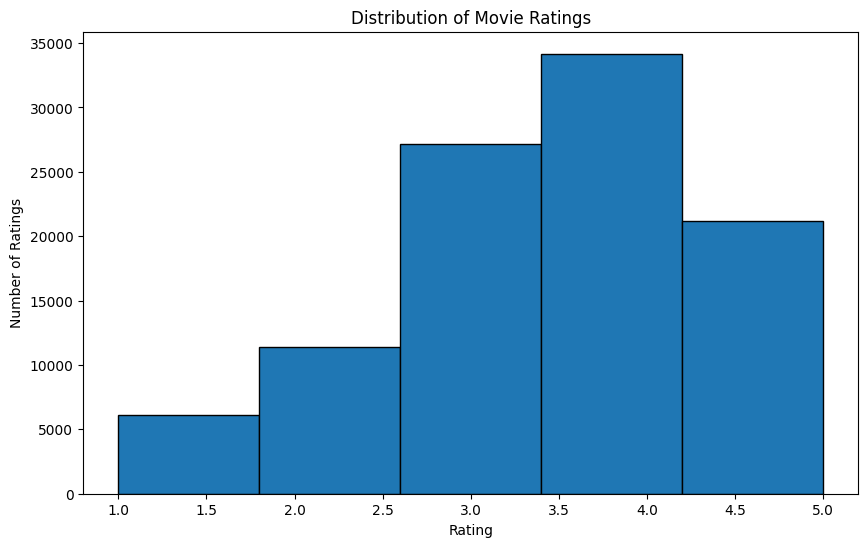

<ipython-input-21-6f80223714bb>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


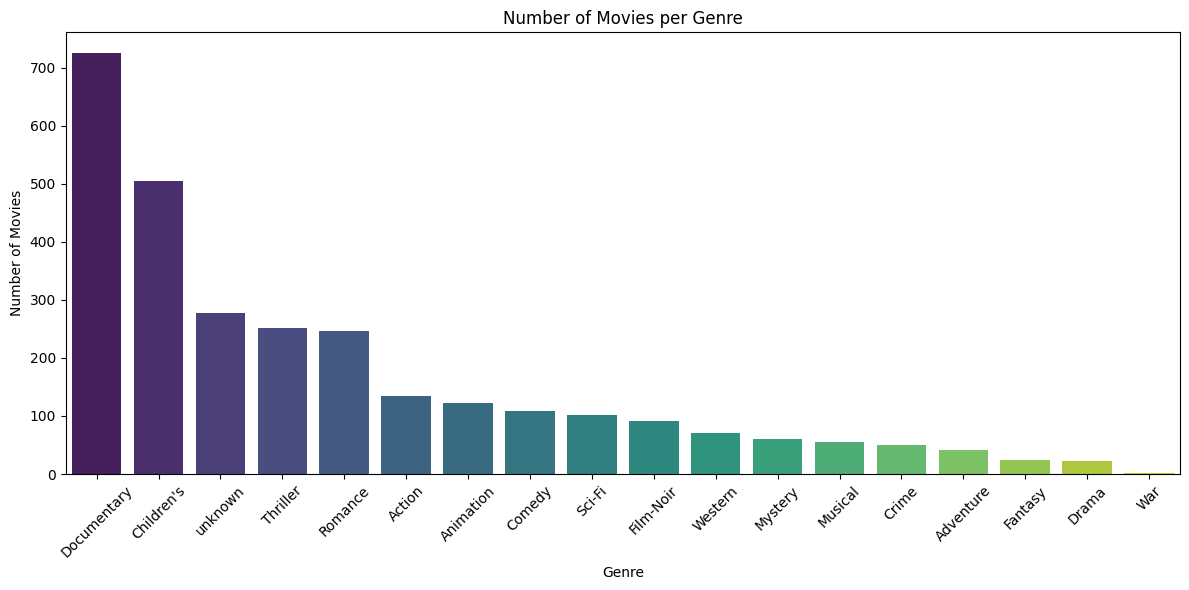

In [21]:
!pip install -q matplotlib pandas tensorflow-datasets

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

# Load the movie metadata
movies_data = tfds.load('movielens/100k-movies', split="train")
ratings_data = tfds.load('movielens/100k-ratings', split="train")

movies_df = tfds.as_dataframe(movies_data)
ratings_df = tfds.as_dataframe(ratings_data)

# Inspect the column names
print(movies_df.columns)
print(ratings_df.columns)

# Output:
# Index(['movie_genres', 'movie_id', 'movie_title'], dtype='object')
# Index(['bucketized_user_age', 'movie_genres', 'movie_id', 'movie_title',
#        'raw_user_age', 'timestamp', 'user_gender', 'user_id',
#        'user_occupation_label', 'user_occupation_text', 'user_rating',
#        'user_zip_code'],
#       dtype='object')

# Select relevant columns from movies and ratings dataframes
movies_df = movies_df[['movie_id', 'movie_title', 'movie_genres']]
ratings_df = ratings_df[['movie_id', 'user_id', 'user_rating']]

# Decode bytes to string where applicable
movies_df['movie_title'] = movies_df['movie_title'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Map genre IDs to genre names
genre_map = {
    0: 'unknown', 1: 'Action', 2: 'Adventure', 3: 'Animation', 4: "Children's",
    5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Fantasy',
    10: 'Film-Noir', 11: 'Horror', 12: 'Musical', 13: 'Mystery', 14: 'Romance',
    15: 'Sci-Fi', 16: 'Thriller', 17: 'War', 18: 'Western'
}

def map_genres(genres):
    return [genre_map.get(genre, 'unknown') for genre in genres]

# Apply genre mapping function
movies_df['movie_genres'] = movies_df['movie_genres'].apply(map_genres)

# Explode genres to have one genre per row
movies_exploded = movies_df.explode('movie_genres')

# Plot distribution of movie ratings
plt.figure(figsize=(10, 6))
plt.hist(ratings_df['user_rating'], bins=5, edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

# Count number of movies per genre
genre_counts = movies_exploded['movie_genres'].value_counts()

# Plot number of movies per genre
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
